In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import requests
import folium
import geopandas as gpd
import json
from shapely.geometry import shape
# import set_matplotlib_hangul
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')


#한글 설정
import platform
from matplotlib import font_manager, rc

get_ipython().run_line_magic("matplotlib", "inline")
# %matplotlib inline

path = "C:/Windows/Fonts/malgun.ttf"

if platform.system() == "Darwin":
    rc("font", family="Arial Unicode MS")
elif platform.system == "Windows":
    font_name = font_manager.Fontproperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unkown system. sorry~~")



In [ ]:
# CSV 파일 읽기
traveler_master = pd.read_csv("data/traveler_master_result.csv")
move = pd.read_csv("data/move_result.csv")
travel = pd.read_csv("data/travel_result.csv")
visit_area = pd.read_csv("data/visit_area_result.csv")

# EDA 정리

1. 나이별, 성별 선호 여행지
2. 여행 일별 분포
3. 목적지간 출발 시간대, 이동 분포(혹은 도별 이동 분포)
4. 여행 장소별 여행 동기
5. 지역에 따른 만족도 높은 장소
6. 여행 스타일에 따른 여행지
7. 거주지 구분에 따른 가고싶은 여행지의 관계(여행 장소 분포)

### 1. 나이별, 성별 선호 여행지

나이에 따른 선호 여행지 분포 : 대체로 나이대 별로 선호 여행지에 대한 향상이 크게 다르지 않음을 판단 할 수 있음. 다만, 20~30대의 여행 빈도가 높음을 알 수 있음.
성별에 따른 선호 여행지 분포 : 대체로 성별에 따른 선호 여행지가 크게 다르지 않음을 알 수 있음. 다만, 여성과 남성의 빈도가 다름을 알 수 있음.

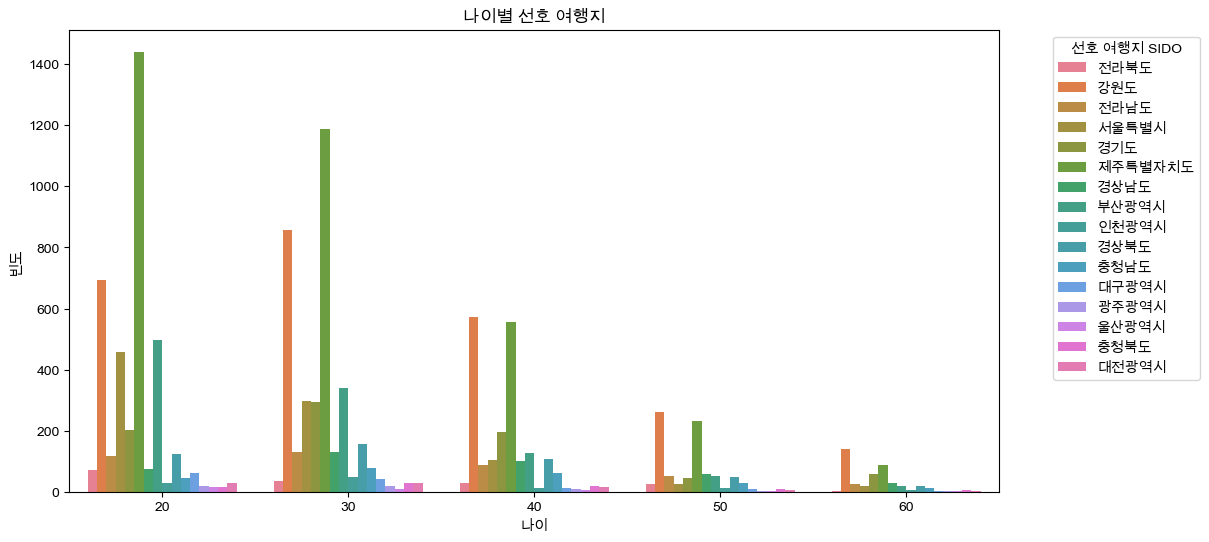

In [3]:
# 나이별 선호 여행지 분석 #라벨 해제로 매핑 추가
mapping_do = {42:'강원도',50:'제주특별자치도',26:'부산광역시',41:'경기도',11:'서울특별시',47:'경상북도',46:'전라남도',48:'경상남도',44:'충청남도',
              45:'전라북도',28:'인천광역시',30:'대전광역시',27:'대구광역시',43:'충청북도',29:'광주광역시',31:'울산광역시'}
traveler_master['TRAVEL_LIKE_SIDO_MAP'] = traveler_master['TRAVEL_LIKE_SIDO_1'].map(mapping_do)

plt.figure(figsize=(12, 6))
sns.countplot(data=traveler_master, x='AGE_GRP', hue='TRAVEL_LIKE_SIDO_MAP')
plt.title('나이별 선호 여행지')
plt.xlabel('나이')
plt.ylabel('빈도')
plt.legend(title='선호 여행지 SIDO', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### 성별 선호 여행지

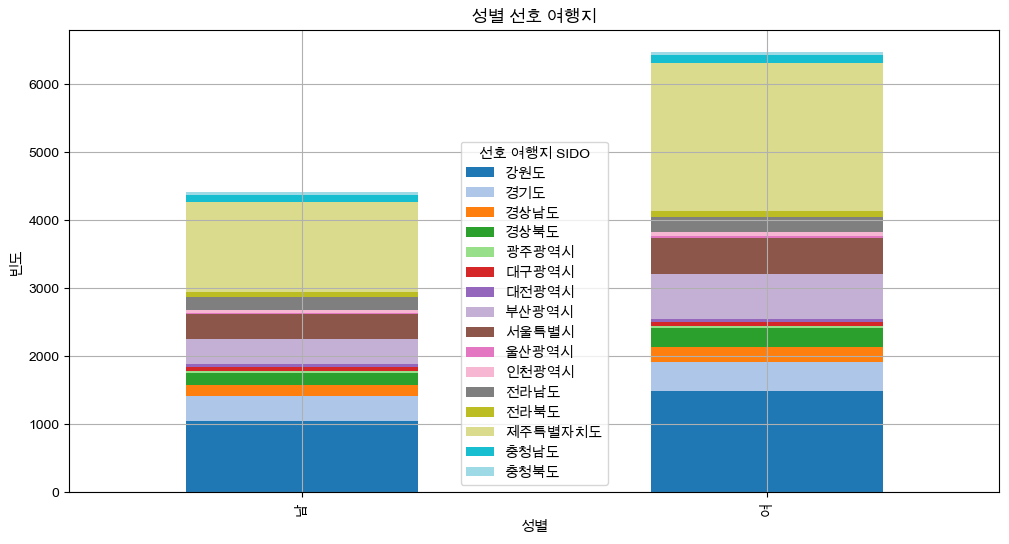

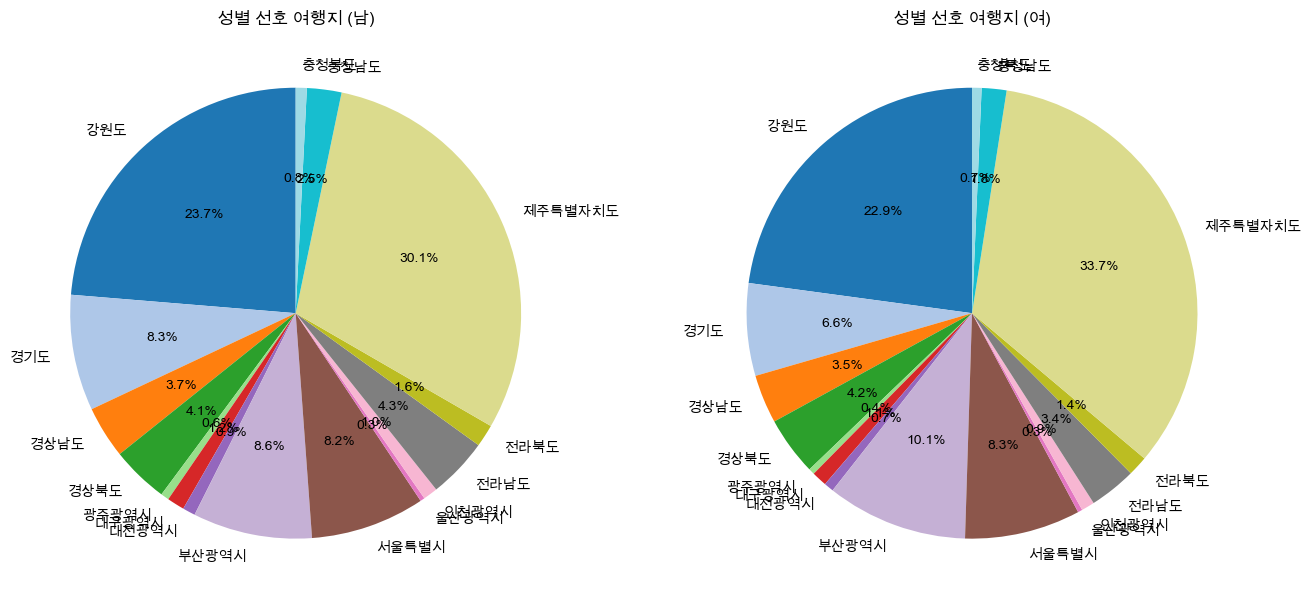

In [164]:
from matplotlib import cm

# 성별 선호 여행지 분석

# 'tab20' 팔레트 사용
unique_categories = traveler_master['TRAVEL_LIKE_SIDO_MAP'].unique()
num_categories = len(unique_categories)
colors = cm.tab20(np.linspace(0, 1, num_categories))


# 스택드 바 차트 (Stacked Bar Chart)
# 필요한 컬럼만 선택
columns_needed = ['GENDER', 'TRAVEL_LIKE_SIDO_MAP']
df = traveler_master[columns_needed]

# 성별 선호 여행지 빈도 계산
gender_group_counts = df.groupby(['GENDER', 'TRAVEL_LIKE_SIDO_MAP']).size().unstack(fill_value=0)

# 스택드 바 차트 시각화
gender_group_counts.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6))
plt.title('성별 선호 여행지')
plt.xlabel('성별')
plt.ylabel('빈도')
plt.legend(title='선호 여행지 SIDO')
plt.grid(True)
plt.show()

# # 파이 차트 (Pie Chart)
gender_sido_counts = df.groupby(['GENDER', 'TRAVEL_LIKE_SIDO_MAP']).size().reset_index(name='counts')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for gender, ax in zip(gender_sido_counts['GENDER'].unique(), axes.flatten()):
    gender_data = gender_sido_counts[gender_sido_counts['GENDER'] == gender]
    ax.pie(gender_data['counts'], labels=gender_data['TRAVEL_LIKE_SIDO_MAP'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'성별 선호 여행지 ({gender})')

plt.show()

### 2. 일별 여행 분포

일별 여행 건수 : 현재 사용하고 있는 데이터들의 여행 시기는 4월 이후 ~ 11월 사이의 여행에 대한 데이터가 많음.
요일별 여행 분포 : 요일 별로 여행자의 수가 유의미하게 차이가 났음을 데이터를 통해 알 수 있었음, 또한, 여행 시작 날짜 및 종료 날짜를 확인해 봤을때, 주말을 이용하여 여행을 갔음을 알 수 있음. 
                다만, 해당 내용이 여행지 장소의 추천과의 상관관계를 받을 수 있는 데이터들이 존재하지 않았다고 판단함.

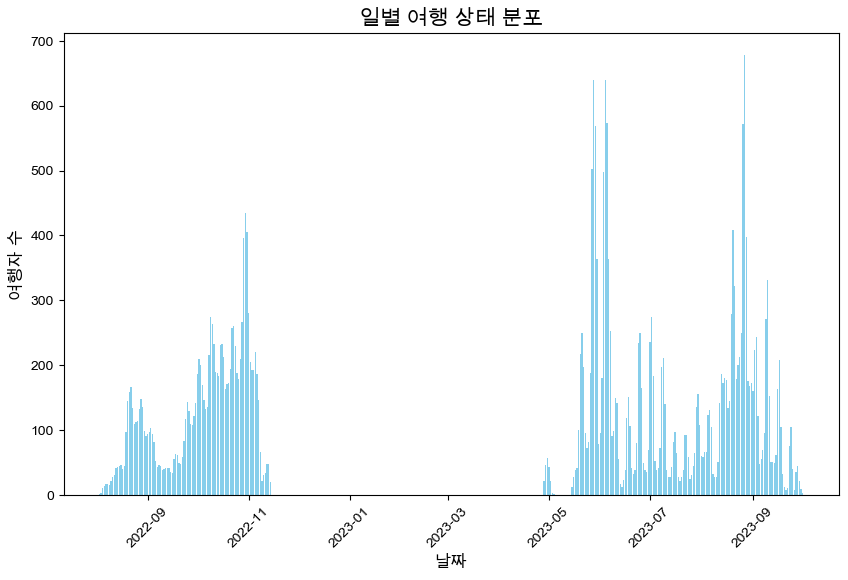

In [55]:
## 일별 여행 건수 분포

#일별 분포 확인을 위한 datetime 변환
travel['start_date'] = pd.to_datetime(travel['TRAVEL_START_YMD'])
travel['end_date'] = pd.to_datetime(travel['TRAVEL_END_YMD'])


# 모든 날짜 범위 생성
dates = pd.date_range(start=travel['start_date'].min(), end=travel['end_date'].max(), freq='D')

# 각 사람별 여행 일정을 일별 분리할 데이터프레임 생성
travel_day = pd.DataFrame(index=dates, columns=travel['TRAVELER_ID'])

# 각 사람의 여행 일정을 반복하며 일별 여행 상태 쪼개기
for index, row in travel.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    travel_days = pd.date_range(start=start_date, end=end_date, freq='D')
    for travel_date in travel_days:
        travel_day.loc[travel_date, row['TRAVELER_ID']] = 1

# NaN 값을 0으로 채우기
travel_day = travel_day.fillna(0).astype(int)

# 각 날짜별로 여행자 수 계산
daily_counts = travel_day.sum(axis=1)

# 막대 그래프로 일별 여행 상태 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(daily_counts.index, daily_counts.values, color='skyblue')
plt.title('일별 여행 상태 분포', fontsize=15)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('여행자 수', fontsize=12)
plt.xticks(rotation=45)

plt.show();

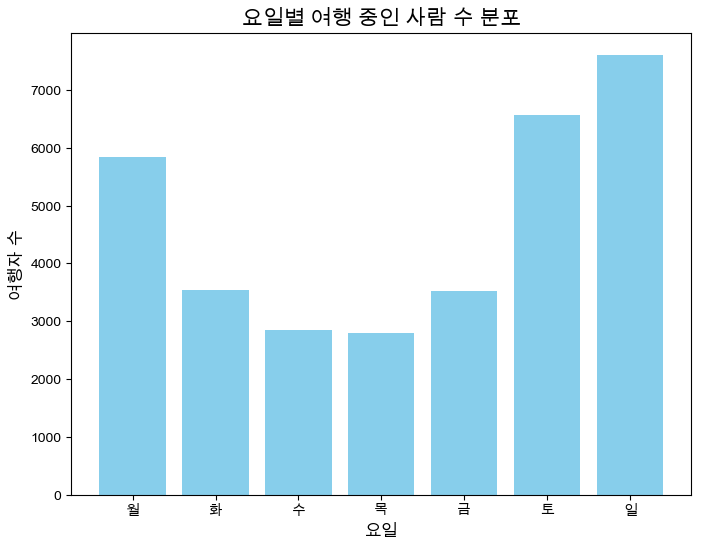

In [56]:
## 요일별 여행 분포

# 각 요일별로 여행 중인 사람 수 계산
weekly_counts = travel_day.groupby(travel_day.index.weekday).sum()

# 요일 이름 매핑
week_names = ['월', '화', '수', '목', '금', '토', '일']

# 막대 그래프로 요일별 여행 상태 분포 시각화
plt.figure(figsize=(8, 6))
plt.bar(week_names, weekly_counts.sum(axis=1), color='skyblue')
plt.title('요일별 여행 중인 사람 수 분포', fontsize=15)
plt.xlabel('요일', fontsize=12)
plt.ylabel('여행자 수', fontsize=12)
plt.xticks(rotation=0)
plt.show()

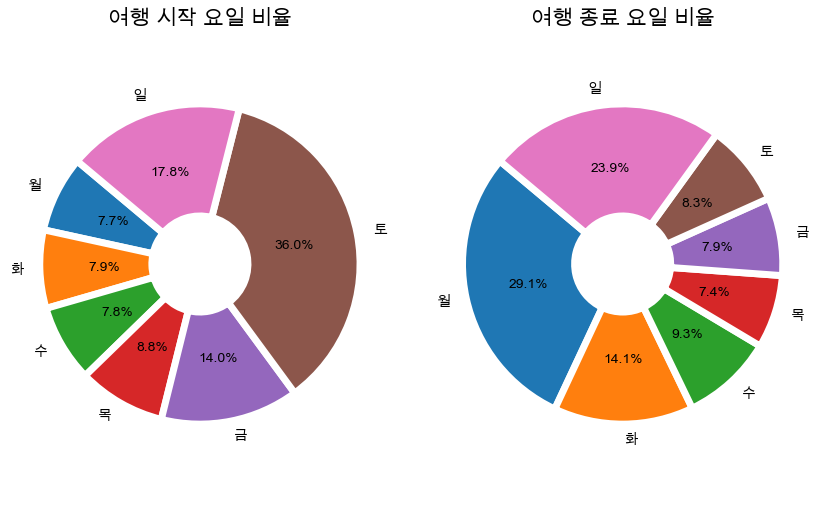

In [61]:
#시작 날짜에 따른 여행일별 분포

# 시작 날짜 여행 건수 계산
daily_travel_c = travel['start_date'].value_counts().sort_index()


# 전체 날짜 범위 생성
full_date = pd.date_range(start=daily_travel_c.index.min(), end=daily_travel_c.index.max())

# 데이터 프레임을 전체 날짜 범위 정렬 및 0 입력
daily_travel_c = daily_travel_c.reindex(full_date, fill_value=0)
daily_travel_c

# 시작 날짜의 요일별 여행 건수 계산
travel['start_day_of_week'] = travel['start_date'].dt.day_name()
week_counts = travel['start_day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)

# 요일 이름 매핑
week_names = ['월', '화', '수', '목', '금', '토', '일']

# 요일별 여행 건수 파이 차트
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.pie(week_counts, labels=week_names, autopct='%1.1f%%', startangle=140,wedgeprops=wedgeprops)
ax1.set_title('여행 시작 요일 비율', fontsize=15)
ax1.axis('equal')

#종료 날짜에 따른 여행일별 분포

# 종료 날짜 여행 건수 계산
daily_travel_end = travel['end_date'].value_counts().sort_index()

# 전체 날짜 범위 생성
full_date = pd.date_range(start=daily_travel_end.index.min(), end=daily_travel_end.index.max())

# 데이터 프레임을 전체 날짜 범위 정렬 및 0 입력
daily_travel_end = daily_travel_end.reindex(full_date, fill_value=0)
daily_travel_end

# 종료 날짜의 요일별 여행 건수 계산
travel['end_day_of_week'] = travel['end_date'].dt.day_name()
week_counts = travel['end_day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)


# 요일별 여행 건수 파이 차트
ax2.pie(week_counts, labels=week_names, autopct='%1.1f%%', startangle=140,wedgeprops=wedgeprops)
ax2.set_title('여행 종료 요일 비율', fontsize=15)
ax2.axis('equal')
plt.show()


### 3. 목적지 간 출발 시간대

출발 시간대 분포 : 2번의 일일 여행 분포의 뒷받침 되는 내용으로 파악하여, 대략적으로 토요일에 출발하는 사람이 많았고, 월요일에 돌아오는 사람이 많았음을 알 수 있음.
                다만, 해당 사항도 2번과 마찬가지로 여행지 장소의 추천과의 상관관계를 받을 수 있는 데이터들이 존재하지 않았다고 판단함.

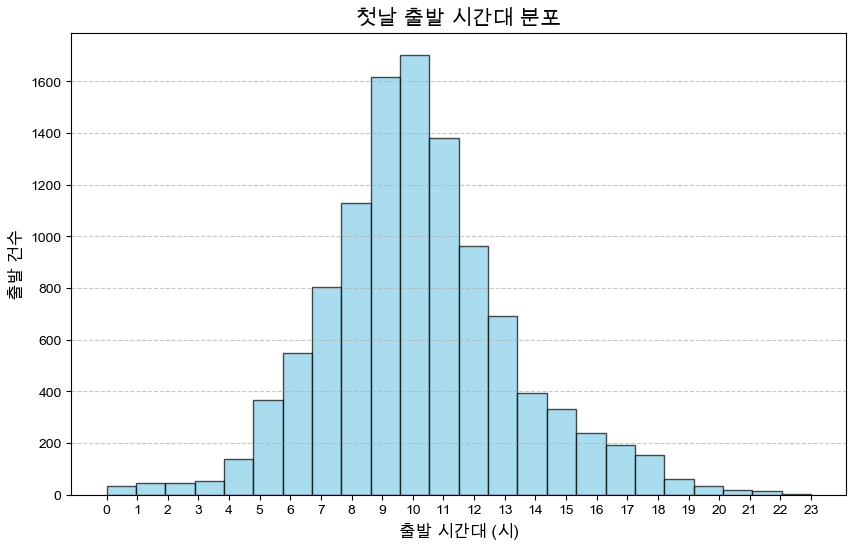

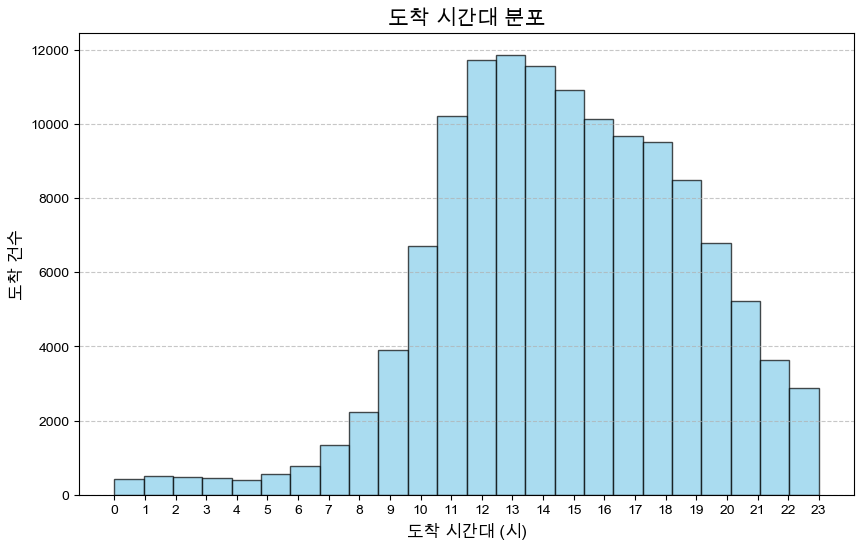

In [62]:
# 출발 시간대 분포
move_start = move.copy()
move_start = move_start.dropna(subset=['START_DT_MIN'])

# 마이크로초를 포함한 부분을 제거하고 초까지만 남기기
move_start['time_str'] = move_start['START_DT_MIN'].apply(lambda x: x[:16])
move_start.tail()

# datetime 변환
move_start['time_str'] = pd.to_datetime(move_start['time_str'])

# 출발 시간대 추출
move_start['start_hour'] = move_start['time_str'].dt.hour

# 출발 시간대 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(move_start['start_hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('첫날 출발 시간대 분포', fontsize=15)
plt.xlabel('출발 시간대 (시)', fontsize=12)
plt.ylabel('출발 건수', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 도착 시간대 분포
move_end = move.copy()
move_end = move_end.dropna(subset=['END_DT_MIN'])

# 마이크로초를 포함한 부분을 제거하고 초까지만 남기기
move_end['time_end'] = move_end['END_DT_MIN'].apply(lambda x: x[:16])

# datetime 변환
move_end['time_end'] = pd.to_datetime(move_end['time_end'])

# 도착 시간대 추출
move_end['end_hour'] = move_end['time_end'].dt.hour

# 도착 시간대 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(move_end['end_hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('도착 시간대 분포', fontsize=15)
plt.xlabel('도착 시간대 (시)', fontsize=12)
plt.ylabel('도착 건수', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 4. 여행 장소별 여행 동기

여행 장소 및 여행동기 상관관계 : 장소에 따른 여행 동기별 분포를 확인할 수 있음. 
                            장소에 따라 여행 동기가 크게 달라지지 않는다고 파악할 수 있으나, 지역에 따라 가장 높은 여행동기가 다름을 알 수 있음.
                            이에 따라 여행장소와 여행 동기의 상관관계는 유의미하다고 파악할 수 있음.

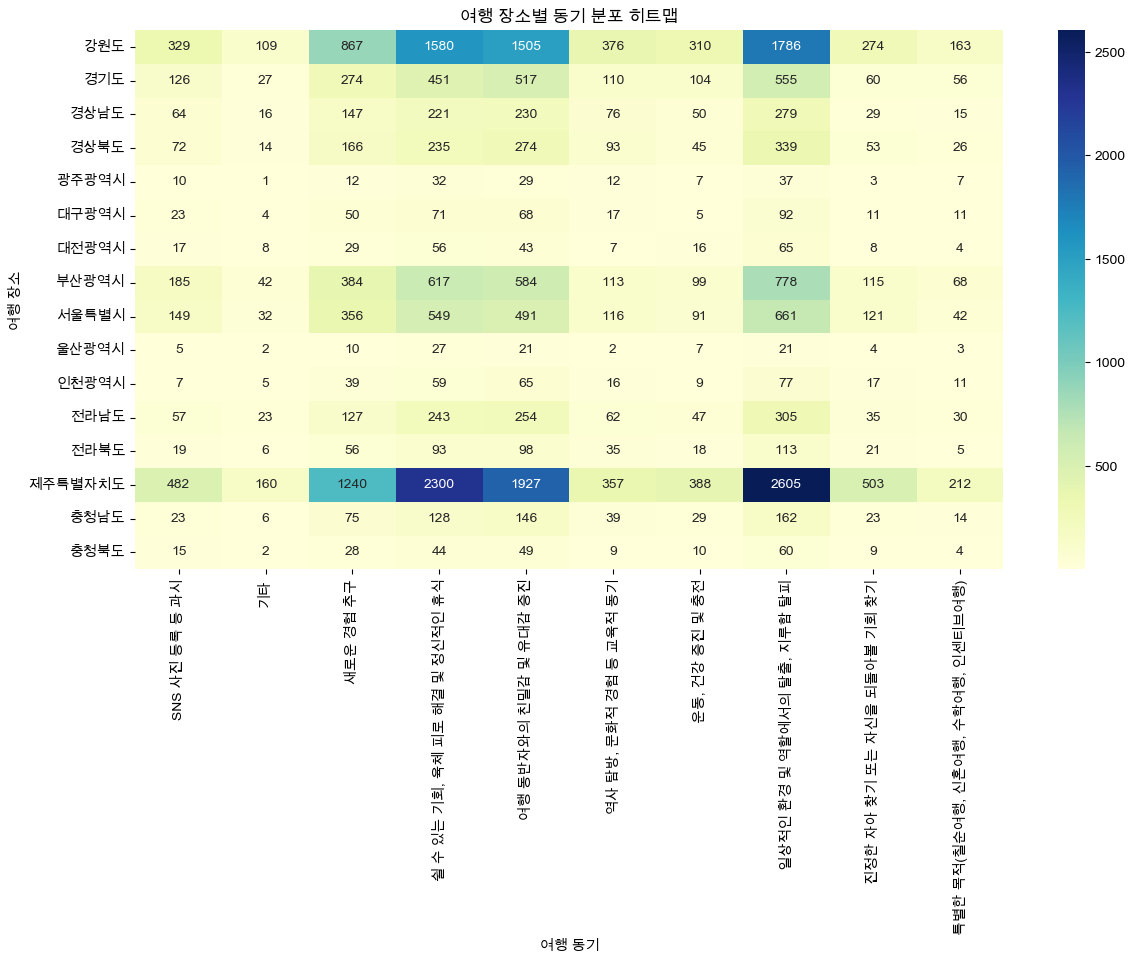

In [154]:
# 라벨링 미적용으로 매핑 추가 
mapping_motive = {1:'일상적인 환경 및 역할에서의 탈출, 지루함 탈피', 2:'쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식', 3:'여행 동반자와의 친밀감 및 유대감 증진',
              4:'진정한 자아 찾기 또는 자신을 되돌아볼 기회 찾기', 5:'SNS 사진 등록 등 과시',6:'운동, 건강 증진 및 충전',7:'새로운 경험 추구',
              8:'역사 탐방, 문화적 경험 등 교육적 동기',9:'특별한 목적(칠순여행, 신혼여행, 수학여행, 인센티브여행)',10:'기타'}
traveler_master['TRAVEL_MOTIVE1_1'] = traveler_master['TRAVEL_MOTIVE_1'].map(mapping_motive)
traveler_master['TRAVEL_MOTIVE1_2'] = traveler_master['TRAVEL_MOTIVE_2'].map(mapping_motive)
traveler_master['TRAVEL_MOTIVE1_3'] = traveler_master['TRAVEL_MOTIVE_3'].map(mapping_motive)



# 여행 장소별 여행 동기 분포 분석
motive_columns = ['TRAVEL_MOTIVE1_1', 'TRAVEL_MOTIVE1_2', 'TRAVEL_MOTIVE1_3']
motive_distribution = traveler_master.groupby('TRAVEL_LIKE_SIDO_MAP')[motive_columns].apply(lambda x: x.stack().value_counts()).unstack().fillna(0)

# 필요한 컬럼만 선택
columns_needed = ['TRAVEL_LIKE_SIDO_MAP', 'TRAVEL_MOTIVE1_1', 'TRAVEL_MOTIVE1_2', 'TRAVEL_MOTIVE1_3']
df = traveler_master[columns_needed]

# 여행 장소별 동기 분포 분석
motive_columns = ['TRAVEL_MOTIVE1_1', 'TRAVEL_MOTIVE1_2', 'TRAVEL_MOTIVE1_3']
motive_distribution = df.melt(id_vars=['TRAVEL_LIKE_SIDO_MAP'], value_vars=motive_columns)
motive_distribution = motive_distribution.groupby(['TRAVEL_LIKE_SIDO_MAP', 'value']).size().reset_index(name='count')

# 여행 장소별 동기 분포 분석
motive_distribution = df.melt(id_vars=['TRAVEL_LIKE_SIDO_MAP'], value_vars=motive_columns)
motive_distribution = motive_distribution.groupby(['TRAVEL_LIKE_SIDO_MAP', 'value']).size().unstack(fill_value=0)

# 히트맵 시각화
plt.figure(figsize=(14, 7))
sns.heatmap(motive_distribution, annot=True, fmt="d", cmap="YlGnBu")
plt.title('여행 장소별 동기 분포 히트맵')
plt.xlabel('여행 동기')
plt.ylabel('여행 장소')
plt.show()

In [148]:
# 필요한 컬럼만 선택
columns_needed = ['TRAVEL_LIKE_SIDO_1', 'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2', 'TRAVEL_MOTIVE_3']
df = traveler_master[columns_needed]

# GeoJSON 파일 로드
geo_path = 'SIDO_MAP.json'  # GeoJSON 파일 경로
with open(geo_path, 'r', encoding='utf-8') as f:
    geo_data = json.load(f)


# 여행 동기에 대한 색상 매핑
motive_colors = {
    '일상적인 환경 및 역할에서의 탈출, 지루함 탈피': '#FF0000',  # red
    '쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식': '#0000FF',  # blue
    '여행 동반자와의 친밀감 및 유대감 증진': '#00FF00',  # green
    '진정한 자아 찾기 또는 자신을 되돌아볼 기회 찾기': '#800080',  # purple
    'SNS 사진 등록 등 과시': '#FFA500',  # orange
    '운동, 건강 증진 및 충전': '#8B0000',  # darkred
    '새로운 경험 추구': '#FF6347',  # lightred
    '역사 탐방, 문화적 경험 등 교육적 동기': '#00008B',  # darkblue
    '특별한 목적(칠순여행, 신혼여행, 수학여행, 인센티브여행)': '#5F9EA0',  # cadetblue
    '기타': '#000000'  # black
}

# 숫자 키를 사용하는 새로운 색상 매핑
motive_numeric = {motive: i for i, motive in enumerate(motive_colors.keys(), 1)}
numeric_to_motive = {v: k for k, v in motive_numeric.items()}
numeric_to_color = {i: color for i, (motive, color) in enumerate(motive_colors.items(), 1)}

# 여행 장소별 동기 분포 계산
def get_top_motive(row):
    motives = row.value_counts()
    return motives.idxmax()

# Apply get_top_motive function
motive_columns = ['TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2', 'TRAVEL_MOTIVE_3']
traveler_master['SET_TOP_MOTIVE'] = traveler_master[motive_columns].apply(get_top_motive, axis=1)
traveler_master['TOP_MOTIVE'] = traveler_master['SET_TOP_MOTIVE'].map(numeric_to_motive) # 라벨링 해제 전 파일이라 내용 추가
traveler_master['TOP_MOTIVE_NUM'] = traveler_master['TOP_MOTIVE'].map(motive_numeric)

# 여행 장소 매핑(라벨링 해제 전 파일)
mapping_do = {42:'강원도',50:'제주특별자치도',26:'부산광역시',41:'경기도',11:'서울특별시',47:'경상북도',46:'전라남도',48:'경상남도',44:'충청남도',
              45:'전라북도',28:'인천광역시',30:'대전광역시',27:'대구광역시',43:'충청북도',29:'광주광역시',31:'울산광역시'}
traveler_master['TRAVEL_LIKE_SIDO_MAP'] = traveler_master['TRAVEL_LIKE_SIDO_1'].map(mapping_do)

# 여행 장소별 동기 분포 계산
motive_distribution = traveler_master.groupby('TRAVEL_LIKE_SIDO_MAP')['TOP_MOTIVE_NUM'].apply(lambda x: x.value_counts().idxmax()).reset_index()
motive_distribution.columns = ['TRAVEL_LIKE_SIDO_MAP', 'TOP_MOTIVE_NUM']

# 지도 생성
m = folium.Map(location=[36.5, 127.5], zoom_start=7)

# Choropleth 추가
for _, row in motive_distribution.iterrows():
    location = row['TRAVEL_LIKE_SIDO_MAP']
    motive_num = row['TOP_MOTIVE_NUM']
    color = numeric_to_color.get(motive_num)
    for feature in geo_data['features']:
        if feature['properties']['CTP_KOR_NM'] == location:
            folium.GeoJson(
                feature,
                style_function=lambda feature, color=color: {
                    'fillColor': color,
                    'color': 'black',
                    'weight': 1,
                    'fillOpacity': 0.7,
                }
            ).add_to(m)

# 범례 추가
legend_html = '''
<div style="position: fixed; 
     bottom: 150px; left: 50px; width: auto; height: auto; 
     background-color: white; z-index:9999; font-size:12px;
     border:2px solid grey; border-radius: 10px; padding: 10px;">
     <b>여행 동기 색상</b><br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #FF0000; margin-right: 5px;"></i> 일상적인 환경 및 역할에서의 탈출, 지루함 탈피<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #0000FF; margin-right: 5px;"></i> 쉴 수 있는 기회, 육체 피로 해결 및 정신적인 휴식<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #00FF00; margin-right: 5px;"></i> 여행 동반자와의 친밀감 및 유대감 증진<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #800080; margin-right: 5px;"></i> 진정한 자아 찾기 또는 자신을 되돌아볼 기회 찾기<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #FFA500; margin-right: 5px;"></i> SNS 사진 등록 등 과시<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #8B0000; margin-right: 5px;"></i> 운동, 건강 증진 및 충전<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #FF6347; margin-right: 5px;"></i> 새로운 경험 추구<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #00008B; margin-right: 5px;"></i> 역사 탐방, 문화적 경험 등 교육적 동기<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #5F9EA0; margin-right: 5px;"></i> 특별한 목적(칠순여행, 신혼여행, 수학여행, 인센티브여행)<br>
     <i style="display: inline-block; width: 12px; height: 12px; background: #000000; margin-right: 5px;"></i> 기타<br>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))
m

### 5. 지역에 따른 만족도 높은 장소

지역에 따른 만족도 : 지역 만족도가 모든 시군구에서 4.0을 넘었고, 지역에 따른 만족도가 여행지 추천에 유의미한 영향을 줄 수 있는 인과관계를 설명하기 어려운 것으로 파악함.

[('제주특별자치도 제주시', 20918), ('제주특별자치도 서귀포시', 13062), ('경북 경주시', 2296), ('강원 강릉시', 2074), ('전북 전주시', 1749), ('전남 여수시', 1742), ('서울 강서구', 1552), ('경기 수원시', 1151), ('대전 중구', 1043), ('인천 중구', 1001), ('전북 군산시', 989), ('서울 용산구', 952), ('부산 해운대구', 936), ('서울 종로구', 874), ('충북 청주시', 840), ('대전 유성구', 740), ('대전 서구', 693), ('경기 가평군', 682), ('대전 동구', 678), ('부산 수영구', 676), ('인천 강화군', 674), ('전남 목포시', 673), ('충남 공주시', 656), ('경남 거제시', 601), ('경남 통영시', 585)]
             sgg    DGSTFN
10        부산 수영구  4.380597
20        전북 전주시  4.376369
9          대전 중구  4.375121
5         경북 경주시  4.374891
8         대전 유성구  4.368785
11       부산 해운대구  4.357374
7          대전 서구  4.350515
0         강원 강릉시  4.340909
13        서울 용산구  4.335463
3         경남 거제시  4.324324
24        충북 청주시  4.306471
2         경기 수원시  4.303191
18        전남 여수시  4.301149
14        서울 종로구  4.296167
12        서울 강서구  4.293500
16         인천 중구  4.291165
21  제주특별자치도 서귀포시  4.284131
22   제주특별자치도 제주시  4.272134
6          대전 동구  4.268546
1         경기 가

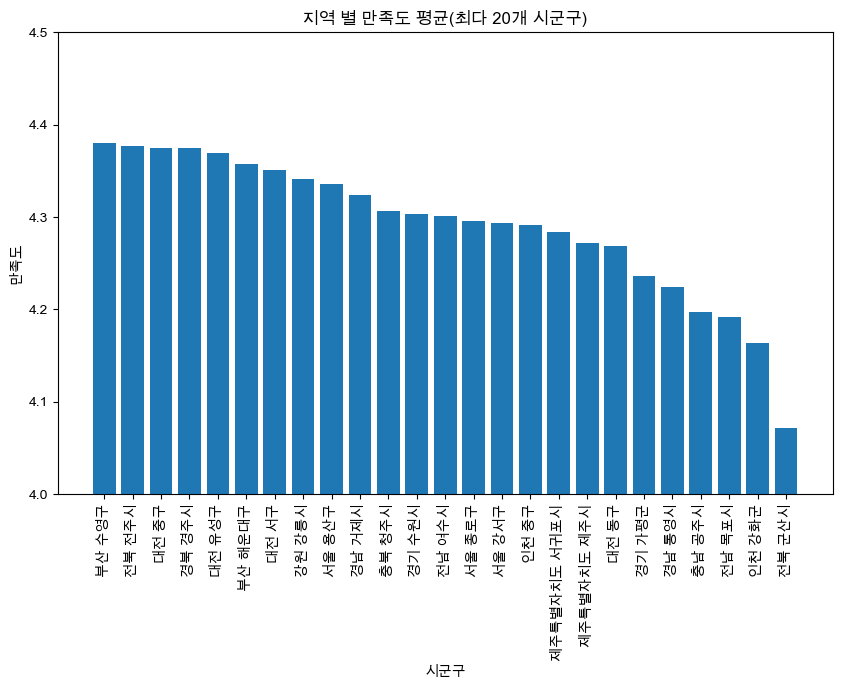

In [150]:

visit_area = visit_area[['VISIT_AREA_NM','ROAD_NM_ADDR','DGSTFN']]

del_list = ['아파트','주차장','호선','올리브영','배스킨라빈스','설빙','롯데리아','맥도날드','탑텐','디저트39','CGV','롯데시네마','ZARA','노래연습장','스타벅스','하나로마트',
            'PC','후루','다이소','홈플러스','롯데마트','이마트','모스버거','이디야','CU','세븐일레븐','GS25', '이마트 24', '아웃백','BBQ','용용 선생','아트박스','무인양품','이니스프리','트레이더스','숙소',
            'ABC마트','인생네컷','메가 MGC 커피','두끼','자라','포토 시그니처','투썸플레이스','마트','하루 필름','펜션','충전소','슬로 캘리','아우어 베이커리','쉐이크쉑','아우어 베이커리','뚜레쥬르','공차',
            '병원','의원','관리','매머드','빽다방','김가네','포토이즘','할머니 맥주','법맥주','금별 맥주','인생 맥주','한라 맥주','달빛 맥주','생활 맥주','샘물 맥주','동대문 엽기 떡볶이','신전 떡볶이','엔제리너스']

for d in del_list:
    visit_area = visit_area[~visit_area['VISIT_AREA_NM'].str.contains(d)]

visit_area = visit_area.dropna(subset=['ROAD_NM_ADDR'])

def region(address):
    parts = address.split()
    return ' '.join(parts[:2])

visit_area['sgg'] = visit_area['ROAD_NM_ADDR'].apply(region)
visit_area['sgg'] = visit_area['sgg'].replace('강원특별자치도 강릉시', '강원 강릉시')

count = Counter(visit_area['sgg'])
count_list = list(count.items())
s_count_list = sorted(count_list, key=lambda x: x[1], reverse=True)[:25]
print(s_count_list)

cnt, mount = zip(*s_count_list)

target_sgg = list(cnt)

find = visit_area[visit_area['sgg'].isin(target_sgg)]
satisfaction = find.groupby('sgg')['DGSTFN'].mean().reset_index()
sort_stf = satisfaction.sort_values(by='DGSTFN', ascending=False)

print(sort_stf)

plt.figure(figsize=(10, 6))
plt.bar(sort_stf['sgg'], sort_stf['DGSTFN'])
plt.xlabel('시군구')
plt.xticks(rotation = 90)
plt.ylabel('만족도')
plt.title('지역 별 만족도 평균(최다 20개 시군구)')
plt.xticks(sort_stf['sgg'])
plt.ylim(4, 4.5)
plt.yticks([4.0, 4.1, 4.2, 4.3, 4.4, 4.5])
plt.show();

### 6. 여행 스타일에 따른 여행지 선정

여행 스타일에 따른 여행지 분포 : 우선 여행 스타일 3가지와 선호 여행지 3군데를 확인해보았을 떄, 각각의 스타일을 가지고 유의미한 상관관계를 파악하기 어려웠음. 여러 여행 스타일을 결합해서 보아야 선호 여행지에 대한 유의미한 내용이 파악 될 것 같다고 생각하여
                        여행 스타일의 전체적인 분포와 선호 여행지에 대한 분포를 조사했을 때, 여행 스타일의 전체적인 분포가 도심 보다 자연 쪽에 많은점과 가장 많이 나온 선호 여행지에 서울특별시 강남구를 제외한 모든 지역이 자연과 관련되어있는 지역이라는 점에서 여행 스타일 항목의 결합 시 선호 여행지의 분류가 유의미할 것이라고 판단하였음.

                        지도로 확인하였을 때는 전체적인 지역에서 강원도, 제주도의 응답률이 높은 것으로 보아, 여행 스타일에 따른 강원도, 제주도의 추천이 높을 것으로 예상함.

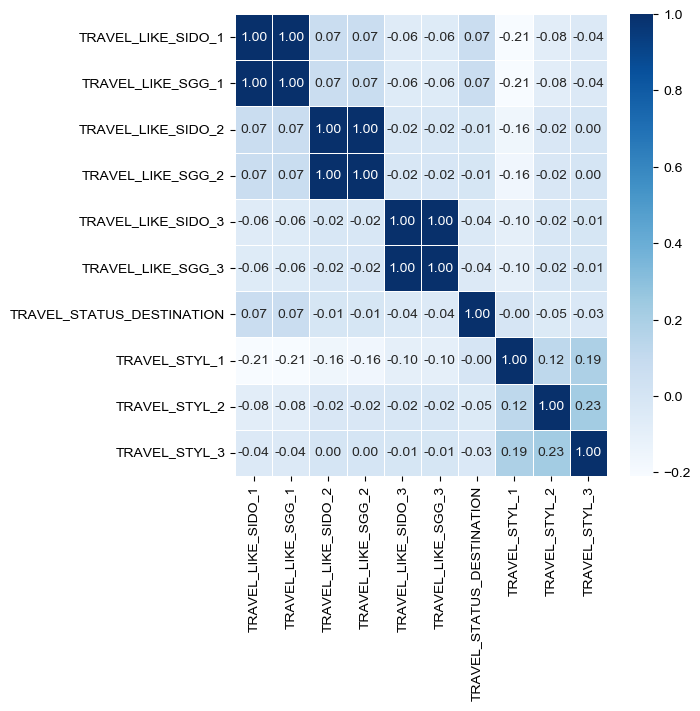

In [151]:
from sklearn.preprocessing import LabelEncoder
model = LabelEncoder()
traveler_master['TRAVEL_STATUS_DESTINATION'] = model.fit_transform(traveler_master['TRAVEL_STATUS_DESTINATION'])
travell = traveler_master[['TRAVEL_LIKE_SIDO_1','TRAVEL_LIKE_SGG_1','TRAVEL_LIKE_SIDO_2','TRAVEL_LIKE_SGG_2','TRAVEL_LIKE_SIDO_3','TRAVEL_LIKE_SGG_3','TRAVEL_STATUS_DESTINATION','TRAVEL_STYL_1','TRAVEL_STYL_2','TRAVEL_STYL_3']]

plt.figure(figsize=(6,6))
sns.heatmap(data = travell.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.show()


[('자연 선호 매우선호', 14435), ('자연 선호 중간선호', 18824), ('자연 선호 약간선호', 12531), ('중립', 15910), ('도시 선호 약간선호', 8709), ('도시 선호 중간선호', 10701), ('도시 선호 매우선호', 5930)]


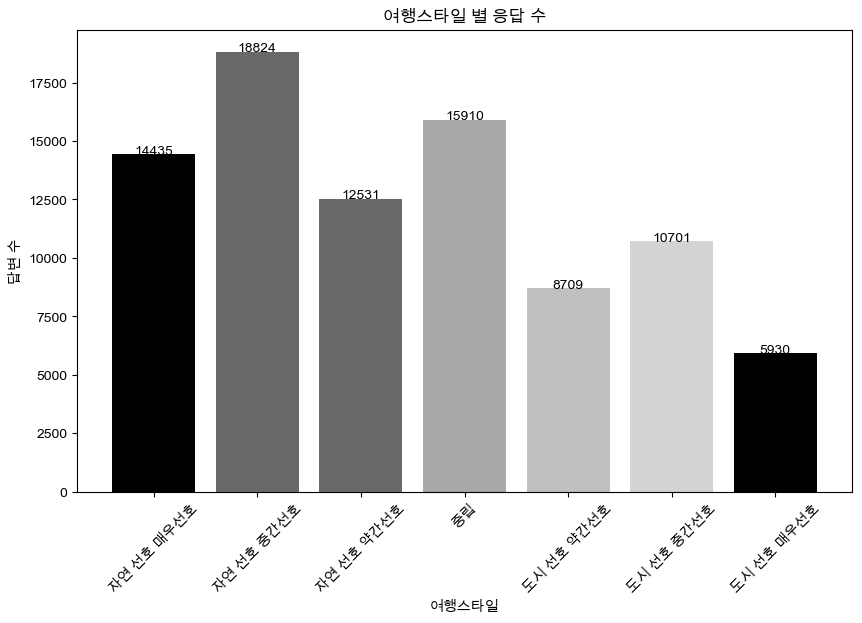

In [152]:
from collections import Counter

comb = ['TRAVEL_STYL_1', 'TRAVEL_STYL_2','TRAVEL_STYL_3','TRAVEL_STYL_4','TRAVEL_STYL_5','TRAVEL_STYL_6','TRAVEL_STYL_7','TRAVEL_STYL_8']
styl = traveler_master[comb].values.flatten().tolist()

code = Counter(styl)
code_list = list(code.items())
s_code_list = sorted(code_list, key=lambda x: x[0])

mapping = {1 :'자연 선호 매우선호', 2:'자연 선호 중간선호', 3:'자연 선호 약간선호', 4:'중립', 5:'도시 선호 약간선호',6:'도시 선호 중간선호', 7:'도시 선호 매우선호'}
mapped = [(mapping[key], value) for key, value in s_code_list]

print(mapped)

elm, freq = zip(*mapped)


colors = ['black','dimgray','dimgrey','darkgray','silver','lightgrey']

plt.figure(figsize=(10, 6))
plt.bar(elm, freq, color=colors)
for i in range(len(elm)):
    plt.text(i,freq[i],freq[i], ha = 'center')
plt.xlabel('여행스타일')
plt.xticks(rotation = 45)
plt.ylabel('답변 수')
plt.title('여행스타일 별 응답 수')
plt.xticks(elm)  # x축 눈금을 요소 값으로 설정
plt.show()

[(50130, 3735), (50110, 3073), (42150, 2677), (26350, 2294), (42210, 1681), (47130, 983), (11680, 840), (46130, 805), (41820, 593), (26500, 539)]
[('제주특별자치도 서귀포시', 3735), ('제주특별자치도 제주시', 3073), ('강원도 강릉시', 2677), ('부산광역시 해운대구', 2294), ('강원도 속초시', 1681), ('경상북도 경주시', 983), ('서울특별시 강남구', 840), ('전라남도 여수시', 805), ('경기도 가평군', 593), ('부산광역시 수영구', 539)]


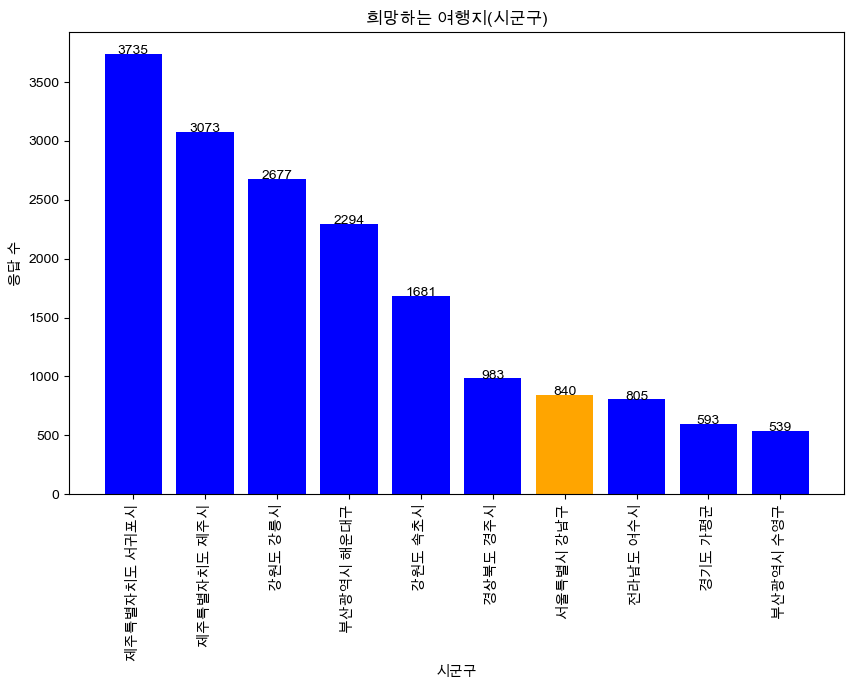

In [153]:
# 시군구
comb = ['TRAVEL_LIKE_SGG_1','TRAVEL_LIKE_SGG_2','TRAVEL_LIKE_SGG_3']
sgg_flat = traveler_master[comb].values.flatten().tolist()

sgg = Counter(sgg_flat)
sgg_list = list(sgg.items())
s_sgg_list = sorted(sgg_list, key=lambda x: x[1], reverse=True)[:10]
print(s_sgg_list)

mapping = {50130:'제주특별자치도 서귀포시', 42150:'강원도 강릉시', 50110:'제주특별자치도 제주시', 26350:'부산광역시 해운대구', 42210:'강원도 속초시',
           47130:'경상북도 경주시', 46130:'전라남도 여수시', 11680:'서울특별시 강남구', 41820:'경기도 가평군', 26500:'부산광역시 수영구'}
mapped = [(mapping[key], value) for key, value in s_sgg_list]

print(mapped)
city, freq = zip(*mapped)

# 막대그래프
plt.figure(figsize=(10, 6))
colors = ['blue'] * len(city)
# 강남구 색상 변경
for i, region in enumerate(city):
    if region == '서울특별시 강남구':
        colors[i] = 'orange'

plt.bar(city, freq, color=colors)
for i in range(len(city)):
    plt.text(i,freq[i],freq[i], ha = 'center')
plt.xlabel('시군구')
plt.xticks(rotation = 90)
plt.ylabel('응답 수')
plt.title('희망하는 여행지(시군구)')
plt.xticks(city)  # x축 눈금을 요소 값으로 설정
plt.show()

In [107]:
# 시도
comb_do = ['TRAVEL_LIKE_SIDO_1','TRAVEL_LIKE_SIDO_2','TRAVEL_LIKE_SIDO_3']
sido_flat = traveler_master[comb_do].values.flatten().tolist()

sido = Counter(sido_flat)
sido_list = list(sido.items())
s_sido_list = sorted(sido_list, key=lambda x: x[1], reverse=True)
print(s_sido_list)

mapping_do = {42:'강원도',50:'제주특별자치도',26:'부산광역시',41:'경기도',11:'서울특별시',47:'경상북도',46:'전라남도',48:'경상남도',44:'충청남도',
              45:'전라북도',28:'인천광역시',30:'대전광역시',27:'대구광역시',43:'충청북도',29:'광주광역시',31:'울산광역시'}
mapped_do = [(mapping_do[key], value) for key, value in s_sido_list]
print(mapped_do)
do, freq_do = zip(*mapped_do)

dosi = pd.DataFrame(mapped_do)

import chardet

with open('Si_Do_map_utf8.json', 'rb') as f:
    result = chardet.detect(f.read())
print(result)

import codecs

# 파일 인코딩 확인
with open('Si_Do_map_utf8.json', 'rb') as f:
    result = chardet.detect(f.read())
print(result)

# 인코딩 변환
input_encoding = result['encoding']
with codecs.open('Si_Do_map_utf8.json', 'r', input_encoding) as f:
    data = f.read()

with codecs.open('Si_Do_map_utf8_converted.json', 'w', 'utf-8') as f:
    f.write(data)

import folium
import json

# 중심 좌표 설정 (위도, 경도)
latitude = 36.5
longitude = 127.5

# 지도 객체 생성
m = folium.Map(location=[latitude, longitude], zoom_start=7)

with open('Si_Do_map_utf8.json', 'r', encoding='euc-kr') as f:
    geo_data = json.load(f)

folium.Choropleth(
    geo_data=geo_data,
    data=dosi, columns=[0,1],
    key_on='feature.properties.CTP_KOR_NM', fill_color='Spectral',
    fill_opacity=1, line_opacity=1, legend_name='시도 별 응답 수'
).add_to(m)

m
    

[(50, 6808), (42, 6568), (26, 4126), (11, 2922), (41, 2756), (47, 1807), (46, 1793), (48, 1482), (44, 879), (45, 785), (28, 710), (27, 537), (30, 502), (43, 476), (29, 259), (31, 230)]
[('제주특별자치도', 6808), ('강원도', 6568), ('부산광역시', 4126), ('서울특별시', 2922), ('경기도', 2756), ('경상북도', 1807), ('전라남도', 1793), ('경상남도', 1482), ('충청남도', 879), ('전라북도', 785), ('인천광역시', 710), ('대구광역시', 537), ('대전광역시', 502), ('충청북도', 476), ('광주광역시', 259), ('울산광역시', 230)]
{'encoding': 'EUC-KR', 'confidence': 0.99, 'language': 'Korean'}
{'encoding': 'EUC-KR', 'confidence': 0.99, 'language': 'Korean'}


### 7. 거주지 구분에 따른 가고싶은 여행지의 관계(여행 장소 분포)

거주지 구분에 따른 여행장소 분포 : 대체적으로 서울, 강원도, 제주도의 응답수가 많았음.
                            그러나, 각 시도별롤 서울, 강원도, 제주도를 제외한 지역에서 자신이 거주하고 있는 지역의 근교로 여행을 가고 싶어하는 비율이 다른 지역에 비해 높음을 알 수 있음.
                            이를 통해 여행지 추천에 있어 거주지에 대한 구분도 유의미 하다고 판단하였음.

In [104]:
# 교차표 분석
residence_sido_crosstab = pd.crosstab(traveler_master['TRAVEL_STATUS_RESIDENCE'], traveler_master['TRAVEL_LIKE_SIDO_1'])
residence_sgg_crosstab = pd.crosstab(traveler_master['TRAVEL_STATUS_RESIDENCE'], traveler_master['TRAVEL_LIKE_SGG_1'])

# 교차표 출력
residence_sido_crosstab

TRAVEL_LIKE_SIDO_1,11,26,27,28,29,30,31,41,42,43,44,45,46,47,48,50
TRAVEL_STATUS_RESIDENCE,,,,,,,,,,,,,,,,
강원도,17,9,0,3,0,1,0,6,84,3,2,3,1,2,3,32
경기도,215,159,12,32,2,8,6,341,935,20,38,17,39,46,35,643
경상남도,28,109,11,0,4,1,1,5,23,0,0,4,15,18,103,111
경상북도,27,60,35,0,0,2,2,2,28,2,0,1,2,60,12,62
광주광역시,49,37,2,1,17,0,0,2,18,2,0,21,129,1,7,129
대구광역시,37,138,25,0,0,0,2,1,21,0,1,2,8,147,23,121
대전광역시,39,25,6,1,0,11,2,6,48,5,47,22,11,11,13,139
부산광역시,57,75,13,1,3,4,10,3,17,1,1,3,16,68,96,173
서울특별시,129,199,13,38,6,21,3,342,1026,18,40,24,59,42,59,999


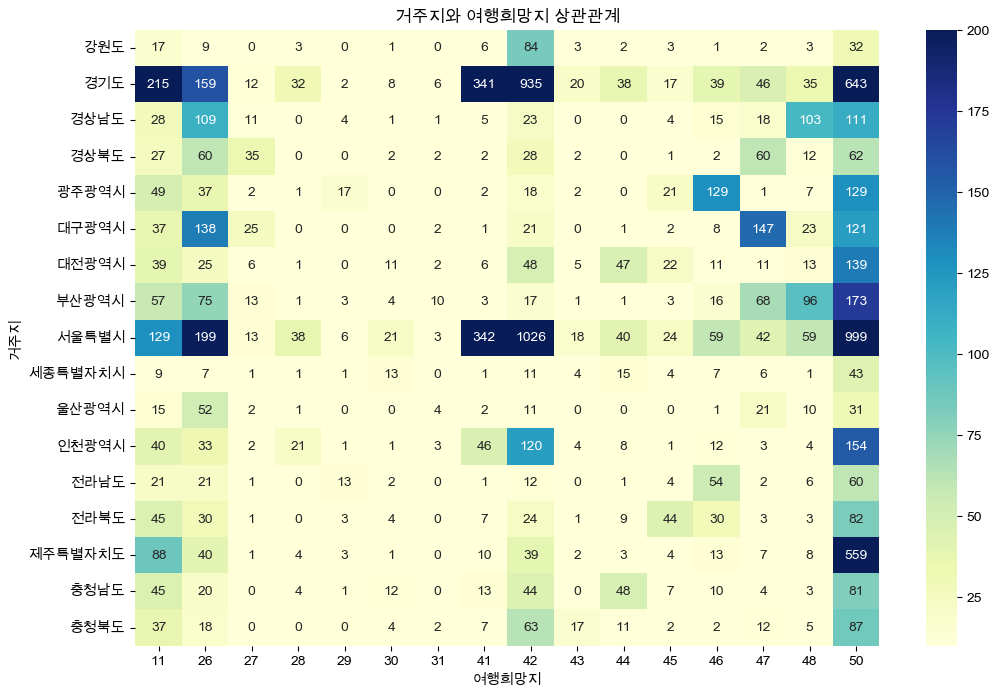

In [105]:
plt.figure(figsize=(12, 8))
sns.heatmap(residence_sido_crosstab, annot=True, fmt="d", cmap="YlGnBu", vmin=10, vmax=200)
plt.title('거주지와 여행희망지 상관관계')
plt.xlabel('여행희망지')
plt.ylabel('거주지')
plt.show()

# 결론

1. 성별, 나이별 여행 분포는 여행지 추천에 유의미한 결과를 내기 어렵다고 볼 수 있다. 
    다만 성별에 따라 나이에 따라 해당 여행지에서 방문하는 장소가 달라질 수 있다고 판단하여 입력 데이터로 반영하는 것으로 머신러닝을 진행할 예정이다.
2. 날짜별 여행 분포는 여행지 추천에 유의미한 결과를 내기 어렵다고 볼 수 있다. 또한 여행을 가는 시기가 여행자 별로 크게 달라지거나 특정하기 어렵기 때문에, 머신러닝을 구현함에 있어 해당 내용은 배제하고 진행 할 예정이다.
3. 목적지간 출발 시간대에 대한 분포도 여행 날짜에 대한 분포의 뒷받침 되는 자료이기 때문에 해당 내용 또한 배제하고 진행해도 여행지 추천에 문제가 없을 것으로 판단하였다.
4. 여행 장소별 여행 동기의 경우 지역별로 응답된 내용이 대부분 비슷하지만 여행 동기로 응답한 값이 다르다고 볼 수 있어 유의미한 차이가 있다고 판단되었다. 다만 3번의 응답이 진행되어야 한다는 점과 응답 내용이 여행 스타일과 비슷하다는 점에서 우선 해당 내용을 배제하고 진행해보기로 결정하였다.
5. 지역에 따른 여행 만족도의 경우 여행지 추천에 유의미한 결과를 내기 어렵다고 판단하여 해당 내용은 배제하고 진행해보기로 결정하였다.
6. 여행 스타일에 따른 여행지의 경우, 도심 및 자연 선호가 명백하게 나뉜다는 점, 데이터의 분포에 비슷한 양상을 띈다는 점에서 유의미한 차이가 있다고 판단하였다. 다만, 여행스타일 1개와 선호 여행지 1개간의 상관관계는 없으므로, 여행 스타일을 3개 이상 가지고 와서 머신러닝의 입력 데이터르 사용하는 방향으로 결정하였다.
7. 거주지 구분에 따른 가고싶은 여행지는 거주지에 따른 주변 여행에 대한 값이 어느정도 나타난다고 파악하여 머신러닝의 입력 데이터로 사용하기로 결정하였다.
